#Imports

In [1]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from datetime import datetime

from PIL import Image
import torchvision.transforms.functional as TF

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Parameters

In [19]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

pixels = 28
batch_size = 64
log_interval = 780
epochs = 30
bottleneck_dim = 32
use_conv = False
plot_images = True
plot_loss = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


# Load data

## MNIST binary

In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

In [4]:
# LOAD BINARY MNIST
x_train, x_valid, x_test = get_binmnist_datasets(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

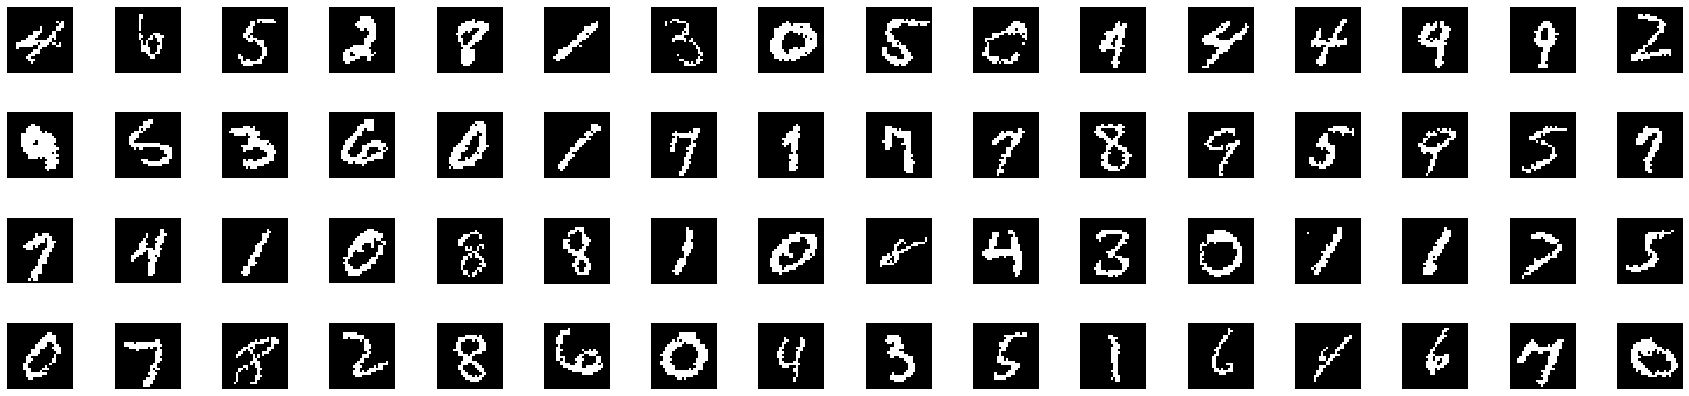

In [5]:
# Plot a few MNIST digit examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.show()

## Quick, Draw!

In [0]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = pixels, pixels, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    #data_dir = "../quickdraw"
    #data_dir = "gdrive/My Drive/DTU/Semester 2"
    categories = ['bucket', 'apple', 'cloud', 'ice cream', 'butterfly', 'sheep', 'truck', 'pig', 't-shirt', 'basket']
    # categories = ['bucket', 'palm tree', 'necklace', 'ice cream', 'butterfly', 'umbrella', 'boomerang', 'pig', 'cat', 'car']

    xpixels = pixels
    ypixels = pixels

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 20000  # number of training images from each category
    n_take_test = 5000   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            img = np.invert(img)
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [0]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/10] Reading category index 0: 'bucket' (124064 images: take 20000 training, take 5000 test)
[2/10] Reading category index 1: 'apple' (144722 images: take 20000 training, take 5000 test)
[3/10] Reading category index 2: 'cloud' (120265 images: take 20000 training, take 5000 test)
[4/10] Reading category index 3: 'ice cream' (123133 images: take 20000 training, take 5000 test)
[5/10] Reading category index 4: 'butterfly' (117999 images: take 20000 training, take 5000 test)
[6/10] Reading category index 5: 'sheep' (126121 images: take 20000 training, take 5000 test)
[7/10] Reading category index 6: 'truck' (131354 images: take 20000 training, take 5000 test)
[8/10] Reading category index 7: 'pig' (186770 images: take 20000 training, take 5000 test)
[9/10] Reading category index 8: 't-shirt' (125233 images: take 20000 training, take 5000 test)
[10/10] Reading category index 9: 'basket' (118458 images: take 20000 training, take 5000 test)


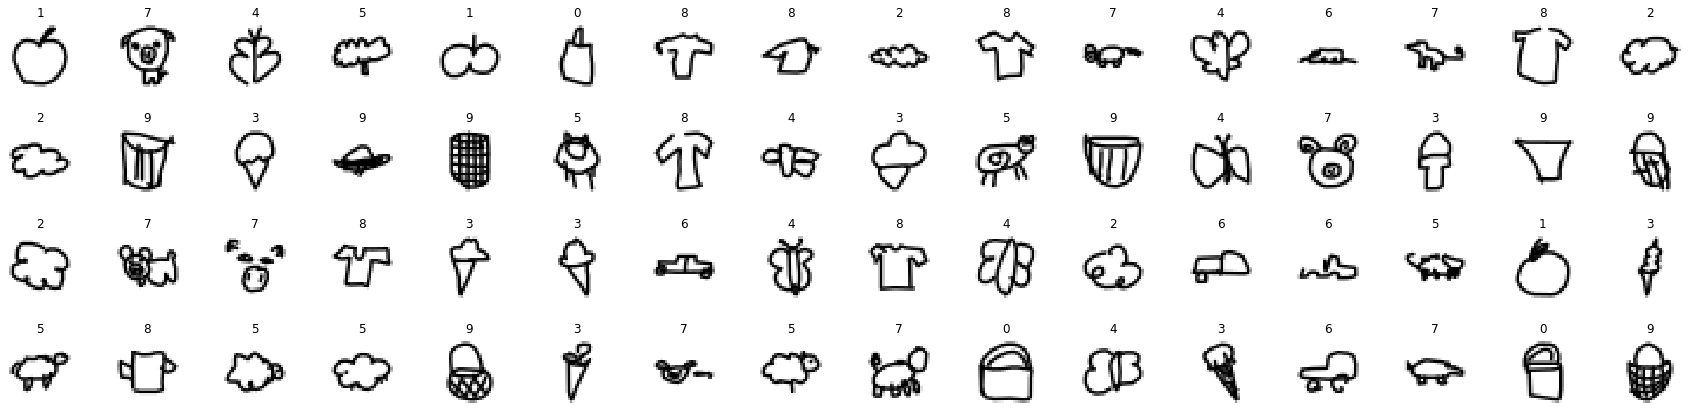

In [0]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(pixels*pixels, 400)
        self.fc21 = nn.Linear(400, bottleneck_dim)
        self.fc22 = nn.Linear(400, bottleneck_dim)
        self.fc3 = nn.Linear(bottleneck_dim, 400)
        self.fc4 = nn.Linear(400, pixels*pixels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, pixels*pixels))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [0]:
ngf = 64
ndf = 64
nc = 1
h_dim=1024

stride = 2
pad = 1
k_dim = 4

class conv_VAE(nn.Module):
    def __init__(self, nz=bottleneck_dim):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, k_dim, stride, pad, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf) x 14 x 14 (25)
            nn.Conv2d(ndf, ndf * 2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), # 
            
            # state size. (ndf*2) x 7 x 7 (21)
            nn.Conv2d(ndf * 2, ndf * 4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU(), #
            
            # state size. (ndf*8) x 4 x 4 (14)
            nn.Conv2d(ndf * 4, 1024, k_dim, stride-1, pad-1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # nn.ReLU() # 
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(1024, ngf*8, k_dim, stride, pad-1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True), # nn.ReLU(), # 
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, k_dim-1, stride, pad, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*4, ngf*2, k_dim, stride, pad, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True), # nn.ReLU(), #
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*2, nc, k_dim, stride, pad, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(h_dim, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, h_dim)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def encode(self, x):
        conv = self.encoder(x);
        h1 = self.fc1(conv.view(-1, h_dim))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,h_dim,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

# Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, pixels*pixels), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()

# Train

In [0]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0

    # for data, _ in train_loader:
    for data in train_loader:
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [0]:
def test(epoch):
    if epoch == 1:
        show_img = True
    else:
        show_img = True if epoch % 10 == 0 else False
        
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        # for data, _ in test_loader: 
        for data in test_loader:
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_all_images(data, recon_batch, bottleneck_dim)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [16]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples for 
def plot_all_images(data, recon_batch, bottleneck_dim):

    f, axarr = plt.subplots(1, 3, figsize=(24, 8))
    rows = 8
    columns = batch_size // rows

    # -- Inputs -- 
    ax = axarr[0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = data[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Reconstructions -- 
    ax = axarr[1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon_batch[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Latent space samples --
    ax = axarr[2]
    ax.set_title('Latent Space Samples')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(64, bottleneck_dim).to(device)
        samples = model.decode(epsilon).cpu()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [0]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    # ELBO loss
    ax1.set_title("ELBO loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

In [0]:
def plot_interpolated_images(images):

    f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
    f.tight_layout()

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(28, 28), cmap="binary_r")
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_tshirt_cloud{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_cloud_sheep{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_butterfly_tshirt_{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_pig_bucket_{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_apple_pig_{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_truck_apple{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_bucket_icecream{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_icecream_basket{i}.png"))
        # save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_basket_sheep{i}.png"))
        save_image(images[i].view(28, 28), os.path.join('gdrive/My Drive/animations_fcff', f"img_butterfly_truck{i}.png"))
        
        ax.axis('off')
    plt.show()

# Main

Using FC FFNN
bottleneck: 32
Train Epoch: 1 [0/60000 (0%)]	Loss: 547.598999
Train Epoch: 1 [49920/60000 (83%)]	Loss: 120.110100
====> Epoch: 1 Average loss: 149.2786


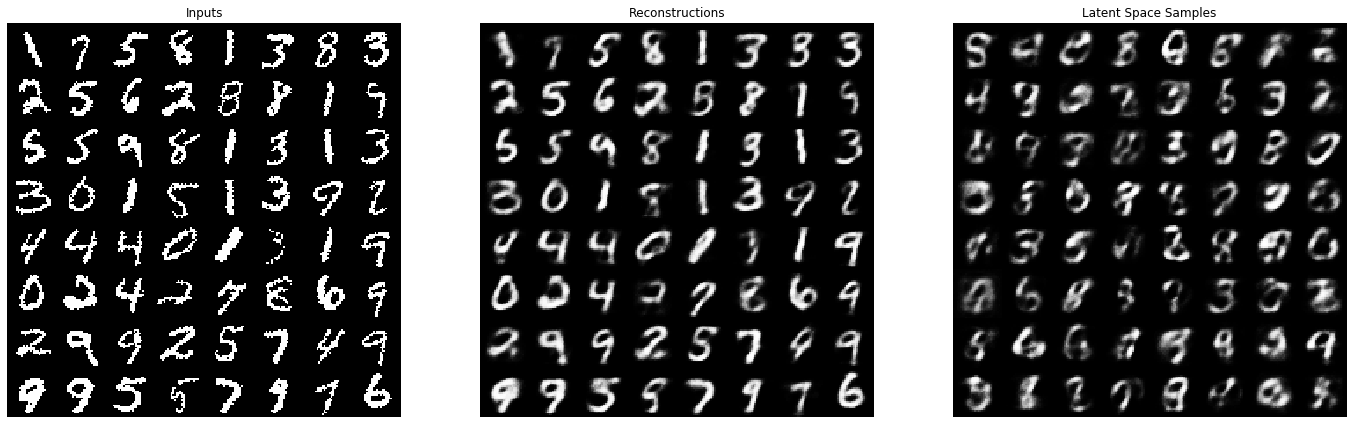

====> Test set loss: 119.5871
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.046181
Train Epoch: 2 [49920/60000 (83%)]	Loss: 108.448921
====> Epoch: 2 Average loss: 114.8320
====> Test set loss: 110.1371
########################################################
Train Epoch: 3 [0/60000 (0%)]	Loss: 113.098846
Train Epoch: 3 [49920/60000 (83%)]	Loss: 112.237953
====> Epoch: 3 Average loss: 108.8870
====> Test set loss: 106.4294
########################################################
Train Epoch: 4 [0/60000 (0%)]	Loss: 108.252472
Train Epoch: 4 [49920/60000 (83%)]	Loss: 104.304840
====> Epoch: 4 Average loss: 106.2935
====> Test set loss: 105.1990
########################################################
Train Epoch: 5 [0/60000 (0%)]	Loss: 108.826256
Train Epoch: 5 [49920/60000 (83%)]	Loss: 97.985733
====> Epoch: 5 Average loss: 104.7721
====> Test set loss: 103.9999
########################################################
Train Epoch: 6 [0/60000 (0%)]	Loss: 101.315079
Train Epoch: 6 [49920/60000 

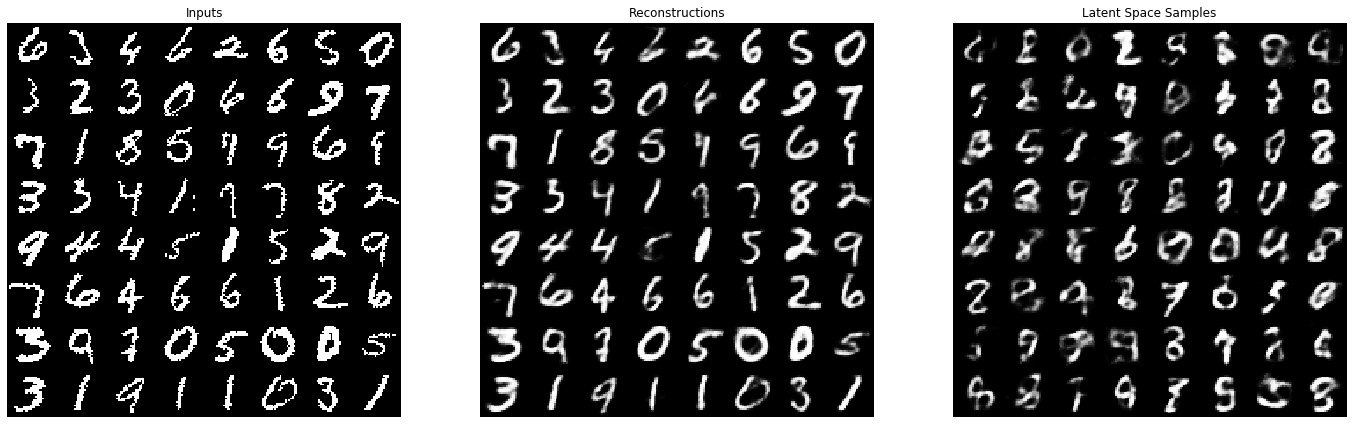

====> Test set loss: 101.5904


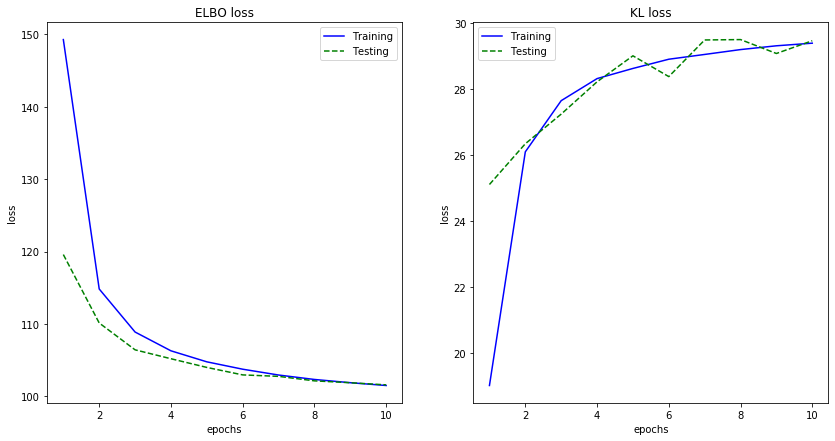

########################################################
Train Epoch: 11 [0/60000 (0%)]	Loss: 105.240433
Train Epoch: 11 [49920/60000 (83%)]	Loss: 96.776276
====> Epoch: 11 Average loss: 101.1455
====> Test set loss: 101.4914
########################################################
Train Epoch: 12 [0/60000 (0%)]	Loss: 96.228897
Train Epoch: 12 [49920/60000 (83%)]	Loss: 94.552979
====> Epoch: 12 Average loss: 100.9083
====> Test set loss: 101.3111
########################################################
Train Epoch: 13 [0/60000 (0%)]	Loss: 96.308357
Train Epoch: 13 [49920/60000 (83%)]	Loss: 103.747925
====> Epoch: 13 Average loss: 100.6703
====> Test set loss: 101.0311
########################################################
Train Epoch: 14 [0/60000 (0%)]	Loss: 104.808044
Train Epoch: 14 [49920/60000 (83%)]	Loss: 105.854019
====> Epoch: 14 Average loss: 100.4342
====> Test set loss: 101.1875
########################################################
Train Epoch: 15 [0/60000 (0%)]	Loss: 97

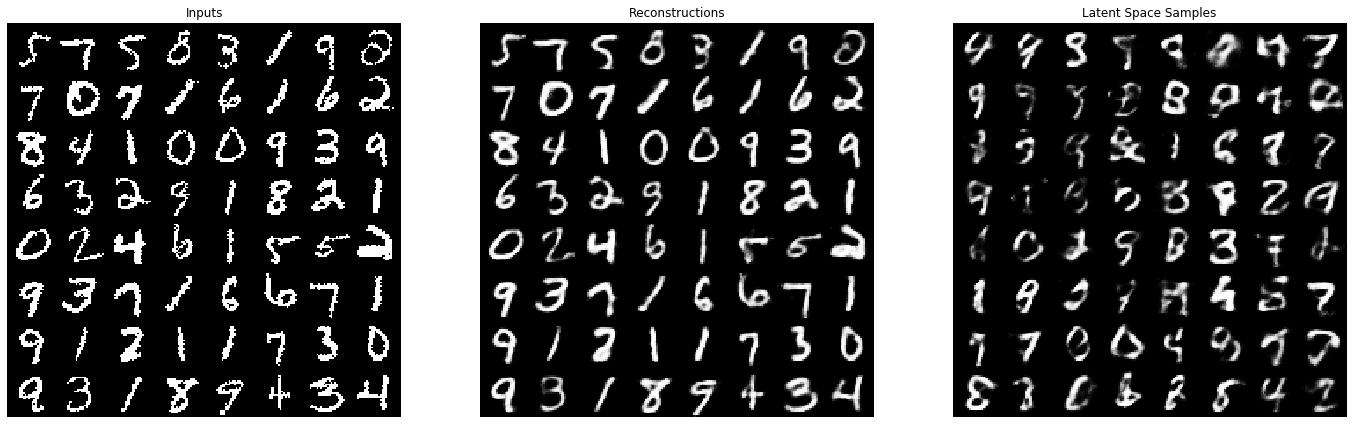

====> Test set loss: 100.3592


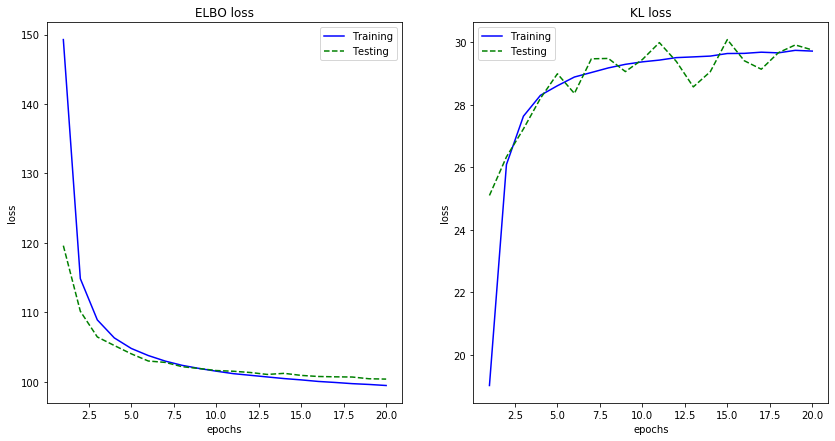

########################################################
Train Epoch: 21 [0/60000 (0%)]	Loss: 98.926102
Train Epoch: 21 [49920/60000 (83%)]	Loss: 101.035217
====> Epoch: 21 Average loss: 99.3091
====> Test set loss: 100.1671
########################################################
Train Epoch: 22 [0/60000 (0%)]	Loss: 96.376411
Train Epoch: 22 [49920/60000 (83%)]	Loss: 97.187355
====> Epoch: 22 Average loss: 99.1369
====> Test set loss: 99.7162
########################################################
Train Epoch: 23 [0/60000 (0%)]	Loss: 99.232628
Train Epoch: 23 [49920/60000 (83%)]	Loss: 99.425079
====> Epoch: 23 Average loss: 99.1397
====> Test set loss: 100.0223
########################################################
Train Epoch: 24 [0/60000 (0%)]	Loss: 105.508255
Train Epoch: 24 [49920/60000 (83%)]	Loss: 97.183609
====> Epoch: 24 Average loss: 99.0559
====> Test set loss: 100.0218
########################################################
Train Epoch: 25 [0/60000 (0%)]	Loss: 94.903168

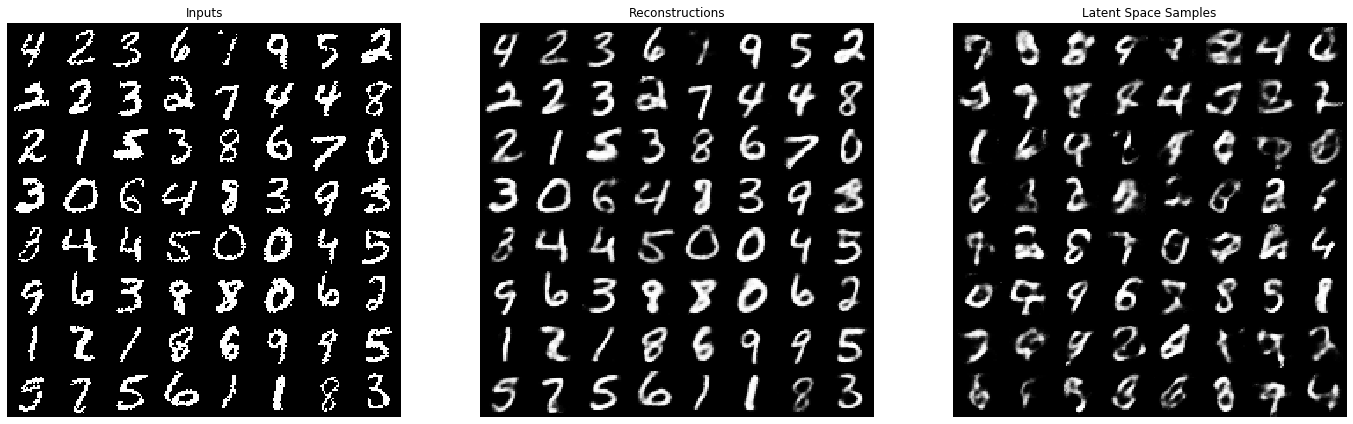

====> Test set loss: 99.5350


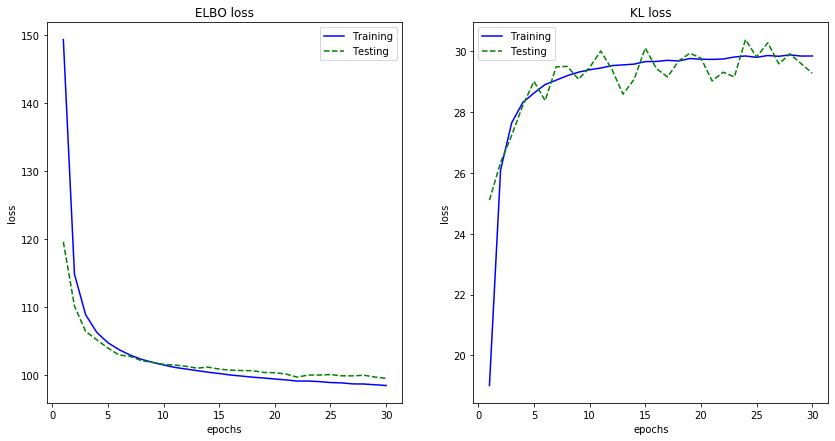

########################################################


In [23]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
print(f'{"using CNN VAE" if use_conv else "using FC FFNN"}')
print(f'bottleneck: {bottleneck_dim}')

optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue
            
        if epoch % 10 ==0:
            plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
            
        print("########################################################")

In [0]:
# Save the trained model
now = datetime.now()
current_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
# filepath = os.path.join("gdrive/My Drive/model", f"trained_{current_datetime}.pt") 
filepath = os.path.join("gdrive/My Drive/DTU/Semester 2", f"mnist_FCNN_30ep_32dim.pt") 
#filepath = os.path.join("./models", f"trained_{current_datetime}_10c.pt") 
torch.save(model.state_dict(), filepath)

# Interpolation

In [0]:
images, labels = next(iter(train_loader))

In [0]:
def interpolate(trn_model, images, idx_from, idx_to, steps):

    # get input images
    # x_from = images[idx_from].unsqueeze(0)
    # x_to = images[idx_to].unsqueeze(0)

    anim_path = "gdrive/My Drive/gif"

    # image = Image.open(os.path.join(anim_path, 'tshirt_3.png'))
    # image = Image.open(os.path.join(anim_path, 'cloud_1.png'))
    # image = Image.open(os.path.join(anim_path, 'butterfly_14.png'))
    # image = Image.open(os.path.join(anim_path, 'bucket_54.png'))
    # image = Image.open(os.path.join(anim_path, 'pig_6.png'))
    # image = Image.open(os.path.join(anim_path, 'apple_10.png'))
    # image = Image.open(os.path.join(anim_path, 'icecream_40.png'))
    # image = Image.open(os.path.join(anim_path, 'basket_34.png'))
    # image = Image.open(os.path.join(anim_path, 'sheep_5.png'))
    image = Image.open(os.path.join(anim_path, 'truck_49.png'))

    x = TF.to_tensor(TF.to_grayscale(image))
    x = x.unsqueeze(0)
    x_from = x
    x_from = x_from if use_conv else x_from.view(-1, pixels*pixels)
    
    # image2 = Image.open(os.path.join(anim_path, 'cloud_1.png'))
    # image2 = Image.open(os.path.join(anim_path, 'sheep_5.png'))
    # image2 = Image.open(os.path.join(anim_path, 'tshirt_3.png'))
    # image2 = Image.open(os.path.join(anim_path, 'pig_6.png'))
    # image2 = Image.open(os.path.join(anim_path, 'apple_10.png'))
    # image2 = Image.open(os.path.join(anim_path, 'truck_49.png'))
    # image2 = Image.open(os.path.join(anim_path, 'bucket_54.png'))
    # image2 = Image.open(os.path.join(anim_path, 'icecream_40.png'))
    # image2 = Image.open(os.path.join(anim_path, 'basket_34.png'))
    image2 = Image.open(os.path.join(anim_path, 'butterfly_14.png'))
    
    x2 = TF.to_tensor(TF.to_grayscale(image2))
    x2 = x2.unsqueeze(0)
    print(x2.shape)
    x_to = x2
    x_to = x_to if use_conv else x_to.view(-1, pixels*pixels)

#     f, axarr = plt.subplots(1, 2, figsize=(16, 4))
#     f.tight_layout()

#     pic = x_from
#     for i, ax in enumerate(axarr.flat):
#         ax.imshow(x_from.view(28, 28), cmap="binary_r")
#         ax.axis('off')
#         pic = x_to
        
#     plt.show()


    interpolate_images(trn_model, x_from, x_to, steps)

def interpolate_images(trn_model, img_from, img_to, steps):

    # get labels
    # lab_to = labels[idx_to]
    # lab_from = labels[idx_from]  

    # get latent space representations of input images
    latent_from = trn_model.reparametrize(*trn_model.encode(img_from.to(device)))
    latent_to = trn_model.reparametrize(*trn_model.encode(img_to.to(device)))

    # actual steps including original images
    n = steps + 1 

    # initialize interpolation vector)
    inter = torch.zeros((n, latent_from.shape[1])).to(device)

    with torch.no_grad():
        alphaValues = np.linspace(0, 1, steps + 1)
        
        for i in range(n):
            alpha = alphaValues[i]
            inter[i] = latent_from * alpha + (1-alpha) * latent_to
        
        output = trn_model.decode(inter).cpu()
        plot_interpolated_images(output)

In [0]:
# Load the model for inference 
# filepath = "./models/trained_26-11-2019_23-40-11_10c.pt"
filepath = "gdrive/My Drive/model/trained_30-11-2019_17-11-34.pt"    # CNN
# filepath = "gdrive/My Drive/model/trained_02-12-2019_11-01-46.pt"  # FC FFNN
trn_model = conv_VAE().to(device) if use_conv else VAE().to(device)
trn_model.load_state_dict(torch.load(filepath))
trn_model.eval()
print(use_conv)

True


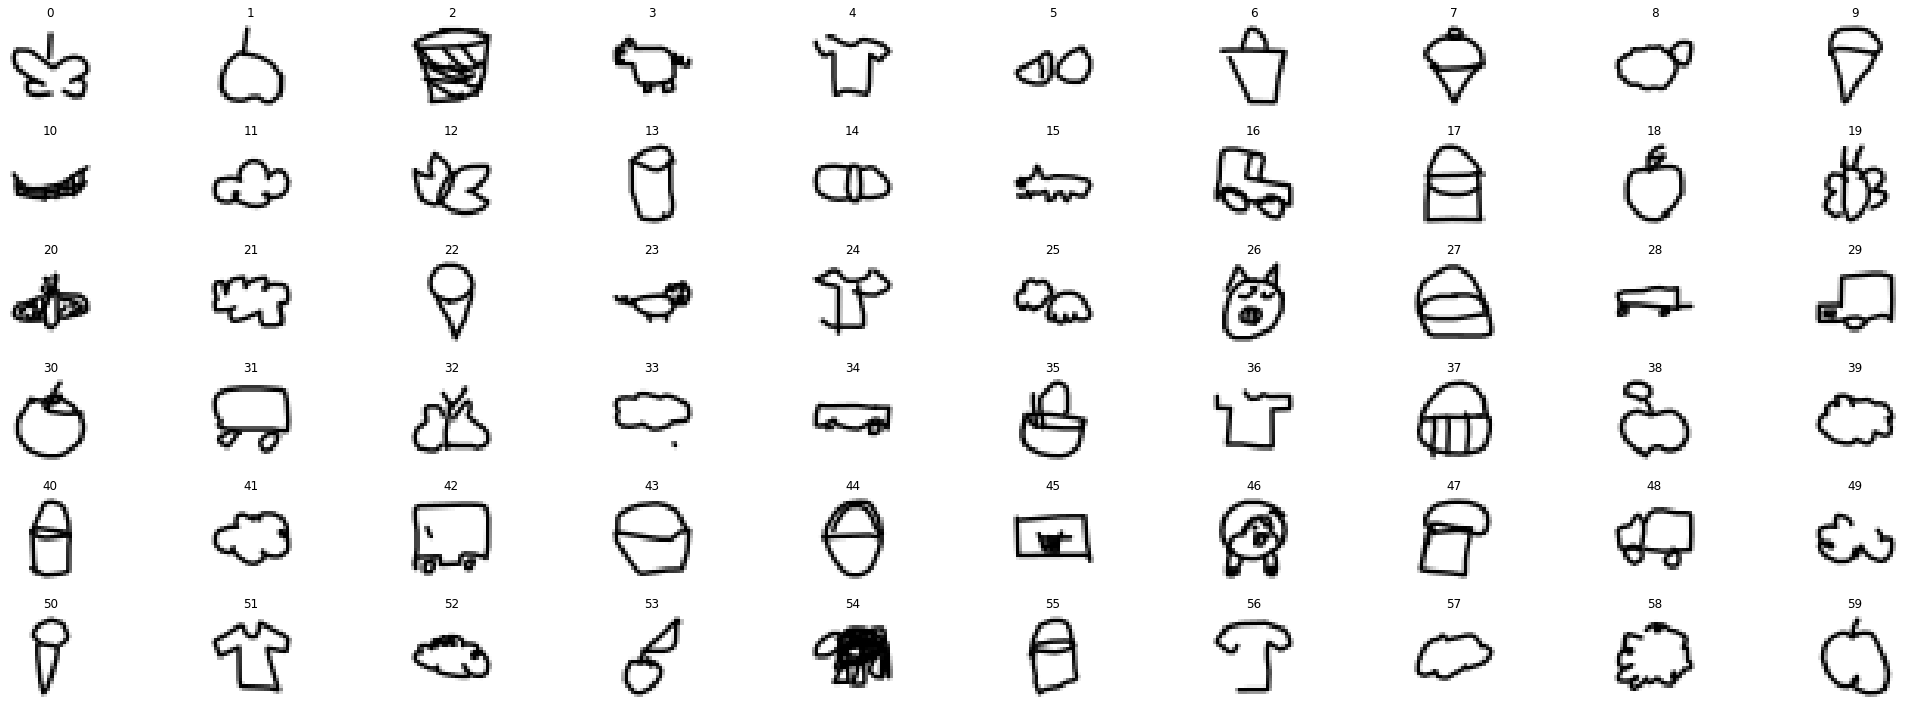

In [0]:
# Show possible images for interpolation
f, axarr = plt.subplots(6, 10, figsize=(28, 10))
f.tight_layout()

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    # ax.title.set_text(labels[i].item())
    ax.title.set_text(i)
    ax.axis('off')
    
plt.show()

torch.Size([1, 1, 28, 28])


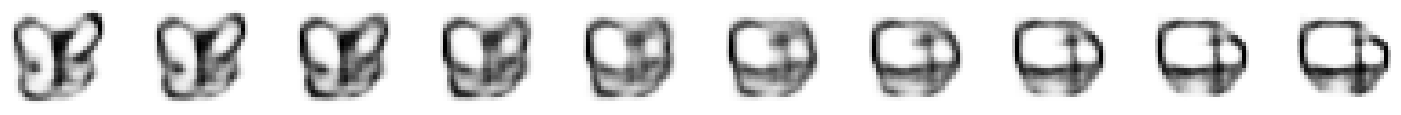

In [0]:
STEPS = 9
INDEX_FROM = -1
INDEX_TO = -1 #10

# i=5
# save_image(images[i], os.path.join("gdrive/My Drive/gif", f"sheep_{i}.png"))
interpolate(trn_model, images, INDEX_FROM, INDEX_TO, STEPS)

# Latent space visualization

In [0]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

def encode_all(model):
    all_input_vectors, tmp_input_vectors = [],[]
    all_latent_vectors, all_labels = [],[]
    tmp_vectors, tmp_labels = [], []
    
    batch_counter = 0
    
    for batch, labels in train_loader:
        
        # comment out line to encode all training data
        if batch_counter == 300:
            break
        
        for image in batch:
            image = image if use_conv else image.view(-1, pixels*pixels)
            image.unsqueeze_(0)
            latent_vector = model.reparametrize(*model.encode(image.to(device)))
            
            tmp_vectors.append(latent_vector.unsqueeze(0))
            tmp_input_vectors.append(image)

        tmp_labels.append(labels)
        batch_counter += 1

    latent_vectors = torch.cat(tmp_vectors)
    input_vectors = torch.cat(tmp_input_vectors)
    all_labels = torch.cat(tmp_labels)

    return latent_vectors, all_labels, input_vectors

def plot_tsne_dots(data_encoded, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        palette = sns.color_palette("Paired", labels.unique().shape[0])
        plt.figure(figsize=(16, 14))
        sns.scatterplot(data_embedded[:,0], data_embedded[:,1], hue=labels, legend='full', palette = palette)

            
def plot_tsne_images(data_encoded, input_images, labels):
    with torch.no_grad():
        data_encoded.squeeze_()
        data_embedded = TSNE(n_components=2).fit_transform(data_encoded.cpu())

        fig, ax = plt.subplots(figsize=(16,14))
        ax.scatter(data_embedded[:,0], data_embedded[:,1],c=labels, cmap='Paired')

        for x, y, image in zip(data_embedded[:,0], data_embedded[:,1], input_images):
            image = image.reshape(28, 28)
            ab = AnnotationBbox(OffsetImage(image.squeeze(), cmap="binary_r"), (x, y), frameon=False)
            ax.add_artist(ab)


In [0]:
data_encoded, labels, inputs = encode_all(trn_model)
print(data_encoded.shape)
print(inputs.shape)

torch.Size([19200, 1, 1, 100])
torch.Size([19200, 1, 784])


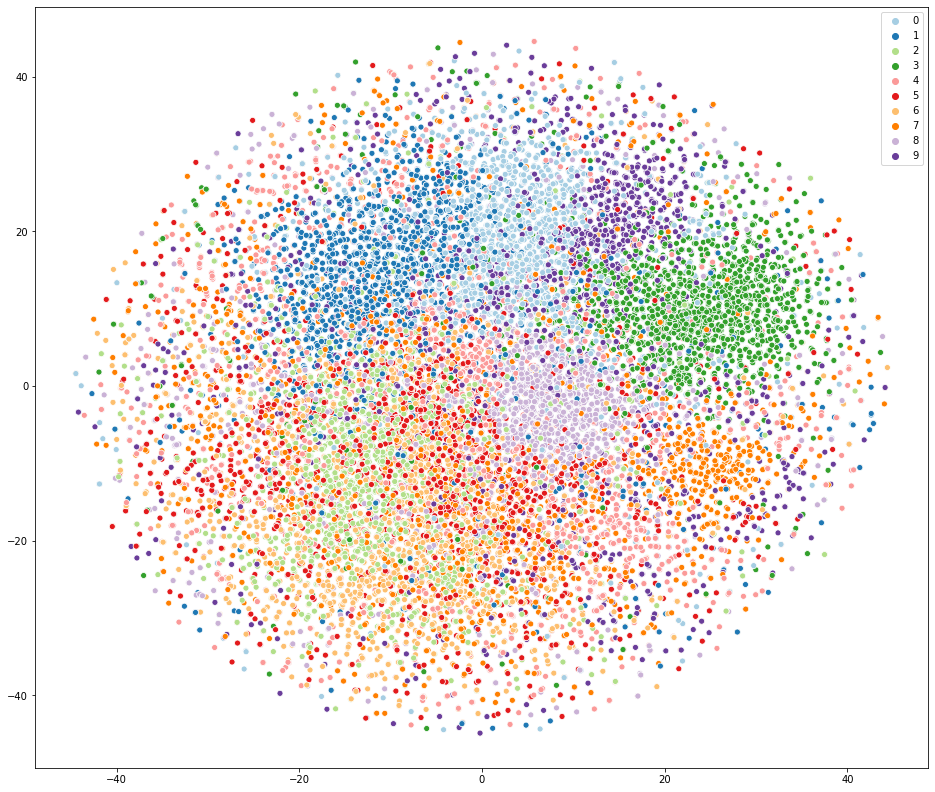

In [0]:
plot_tsne_dots(data_encoded, labels)

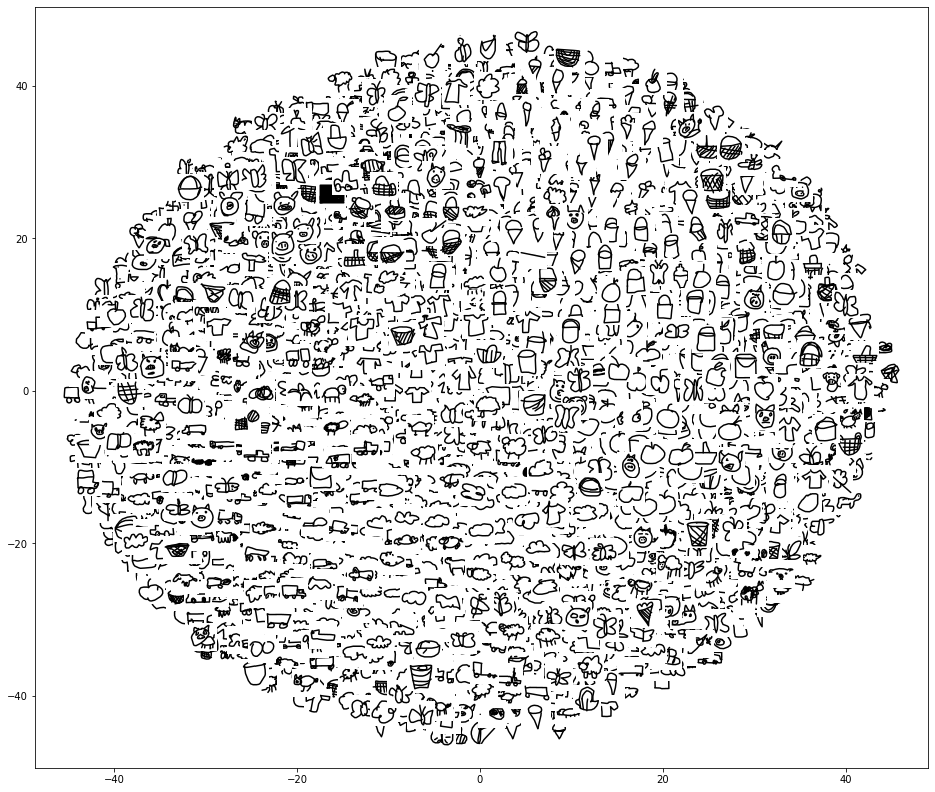

In [0]:
plot_tsne_images(data_encoded, inputs, labels)

In [0]:
def modified_brownian_motion(dim, n_steps=1000, alpha=0.5):
    """
    params:
        dim:        Dimensionality of the space the Brownian motion process
        n_steps:    Int representing the number of steps the Brownian motion
                    process will run for.
        delta_t:    Float representing time discretization. 
                    Should be sufficiently small
        alpha:      Interpolation coefficient. Should be in (0, 1).
    """
    delta_t = 1/n_steps
    samples = torch.zeros([n_steps, dim])
    samples[0] = torch.randn([dim])

    for i in range(1, n_steps):
      samples[i] = samples[i-1] + np.sqrt(delta_t) * torch.randn([dim])
      # samples[i] = (1-alpha) *samples[i-1] + alpha * torch.randn([dim])
    return samples

In [0]:
N = 10000
samples = modified_brownian_motion(bottleneck_dim, n_steps=N, alpha=0.5)
dir_random_walk = "gdrive/My Drive/random_walk_1"

with torch.no_grad():
  for j in range(N):
    sample = trn_model.decode(samples[j].cuda())
    save_image(sample.view(28, 28), os.path.join(dir_random_walk, f"img_{j}.png"))

In [0]:
# f, axarr = plt.subplots(int(N/10), int(N/20), figsize=(24*5, 8*5))
# f.tight_layout()

# with torch.no_grad():
#   for i, ax in enumerate(axarr.flat):
#       ax.imshow(all_samples[i].cpu().view(28, 28), cmap="binary_r")
#       # print(samples_rand[i])
#       ax.axis('off')
    
# plt.show()